In [1]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
from torchsummary import summary as summary_
import matplotlib.pyplot as plt
import numpy as np


c:\Users\user\.conda\envs\test\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\user\.conda\envs\test\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\user\.conda\envs\test\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cpu


In [3]:
EPOCH = 30
BATCH_SIZE = 64
NUM_WORKERS = 2
learning_rate = 0.005

In [4]:
# Fashion MNIST 데이터셋 불러오기
trainset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = True,
    download  = True,
    transform = transforms.ToTensor()
)

testset = datasets.FashionMNIST(
    root      = './.data/', 
    train     = False,
    download  = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset     = trainset,
    batch_size  = BATCH_SIZE,
    shuffle     = True,
    num_workers = NUM_WORKERS
)

test_loader = torch.utils.data.DataLoader(
    dataset     = testset,
    batch_size  = BATCH_SIZE,
    shuffle     = False,
    num_workers = NUM_WORKERS
)

In [5]:
# 오토인코더 모듈 정의
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),

            nn.Linear(32, 3),
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # 픽셀당 0과 1 사이로 값을 출력하는 sigmoid()함수를 추가합니다.
        )

    def forward(self, x):
        encoded = self.encoder(x) # encoder는 encoded라는 latent_vector를 만들고
        decoded = self.decoder(encoded) # decoder를 통해 decoded라는 복원이미지를 만듭니다.
        return encoded, decoded

In [6]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=learning_rate) 
criterion = nn.MSELoss() 

In [7]:
summary_(autoencoder.encoder, (28*28,) ,batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [64, 128]         100,480
              ReLU-2                  [64, 128]               0
            Linear-3                   [64, 32]           4,128
              ReLU-4                   [64, 32]               0
            Linear-5                    [64, 3]              99
Total params: 104,707
Trainable params: 104,707
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.16
Params size (MB): 0.40
Estimated Total Size (MB): 0.75
----------------------------------------------------------------


In [8]:
summary_(autoencoder.decoder, (3,) ,batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [64, 32]             128
              ReLU-2                   [64, 32]               0
            Linear-3                  [64, 128]           4,224
              ReLU-4                  [64, 128]               0
            Linear-5                  [64, 784]         101,136
           Sigmoid-6                  [64, 784]               0
Total params: 105,488
Trainable params: 105,488
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.92
Params size (MB): 0.40
Estimated Total Size (MB): 1.33
----------------------------------------------------------------


In [9]:
# 원본 이미지를 시각화 하기
view_data = testset.data[:10].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.
#픽셀의 색상값이 0~255이므로 모델이 인식하는 0부터 1사이의 값으로 만들기 위해 255로 나눠줍니다.

In [10]:
# 학습하기 위한 함수
def train(autoencoder, train_loader):
    autoencoder.train()
    total_loss=0
    for step, (x, label) in enumerate(train_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y)
        total_loss = total_loss + loss
        optimizer.zero_grad() #기울기에 대한 정보를 초기화합니다.
        loss.backward() # 기울기를 구합니다.
        optimizer.step() #최적화를 진행합니다.

    total_loss = total_loss.item()
    print("total train loss:" + str(total_loss))
    
    return total_loss

In [11]:
def test(autoencoder, test_loader):
    autoencoder.eval()
    total_loss=0
    for step, (x, label) in enumerate(test_loader):
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        label = label.to(DEVICE)

        encoded, decoded = autoencoder(x)

        loss = criterion(decoded, y)
        total_loss = total_loss + loss


    total_loss = total_loss.item()
    print("total test loss:" + str(total_loss))
    
    return total_loss

total train loss:29.46976089477539
total test loss:4.123715877532959
[Epoch 1]


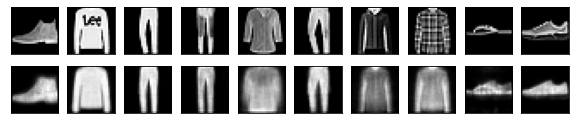

total train loss:22.832788467407227
total test loss:3.728712797164917
[Epoch 2]


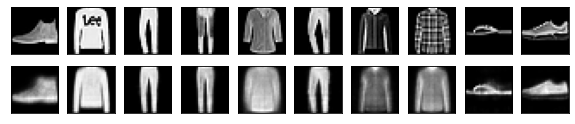

total train loss:21.75156593322754
total test loss:3.5955810546875
[Epoch 3]


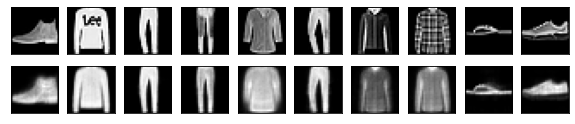

total train loss:21.265138626098633
total test loss:3.55582857131958
[Epoch 4]


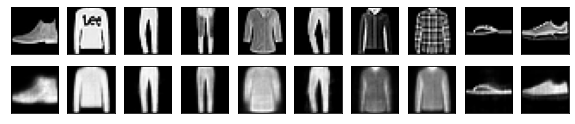

total train loss:20.919490814208984
total test loss:3.501844882965088
[Epoch 5]


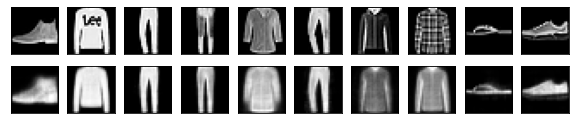

total train loss:20.72370147705078
total test loss:3.5099985599517822
[Epoch 6]


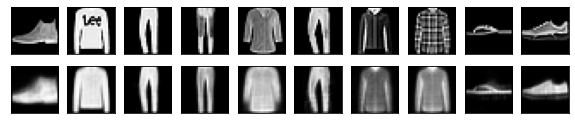

total train loss:20.54232406616211
total test loss:3.4609763622283936
[Epoch 7]


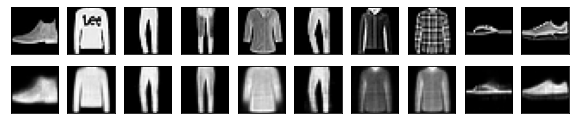

total train loss:20.33962059020996
total test loss:3.5146098136901855
[Epoch 8]


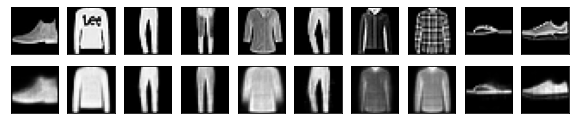

total train loss:20.315937042236328
total test loss:3.404693365097046
[Epoch 9]


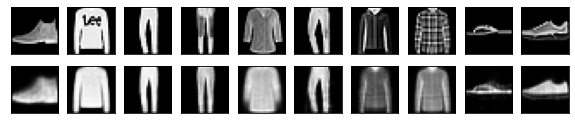

total train loss:20.168106079101562
total test loss:3.4046287536621094
[Epoch 10]


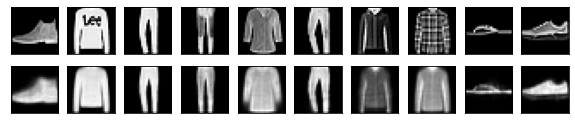

total train loss:20.125167846679688
total test loss:3.4430670738220215
[Epoch 11]


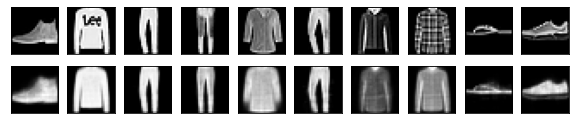

total train loss:20.09564781188965
total test loss:3.457096576690674
[Epoch 12]


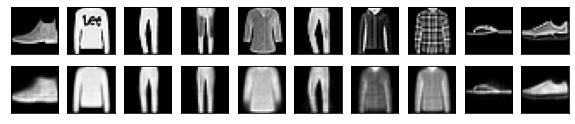

total train loss:19.974462509155273
total test loss:3.416170597076416
[Epoch 13]


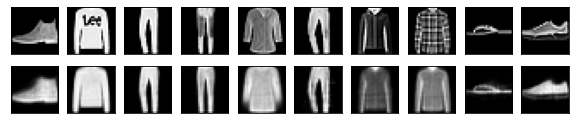

total train loss:19.946949005126953
total test loss:3.3507981300354004
[Epoch 14]


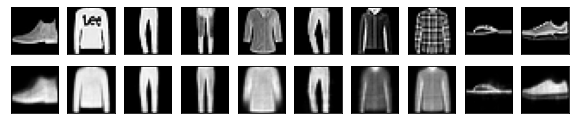

total train loss:19.905078887939453
total test loss:3.354579210281372
[Epoch 15]


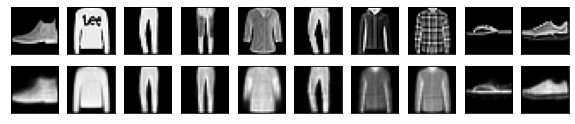

total train loss:19.893768310546875
total test loss:3.358966827392578
[Epoch 16]


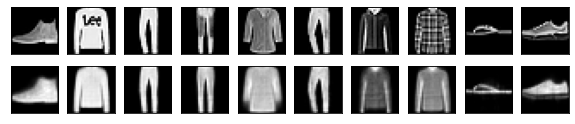

total train loss:19.826871871948242
total test loss:3.407573938369751
[Epoch 17]


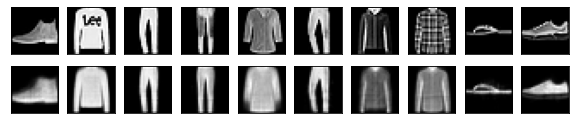

total train loss:19.802982330322266
total test loss:3.3493409156799316
[Epoch 18]


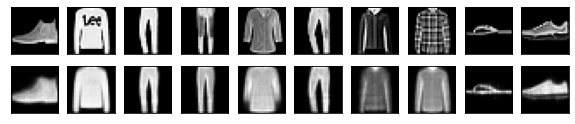

total train loss:19.758806228637695
total test loss:3.3462941646575928
[Epoch 19]


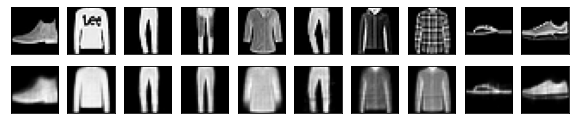

total train loss:19.720806121826172
total test loss:3.329397678375244
[Epoch 20]


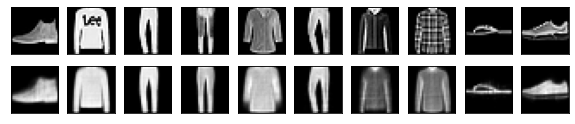

total train loss:19.70066261291504
total test loss:3.394540309906006
[Epoch 21]


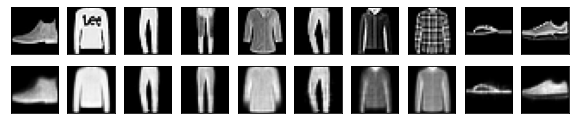

total train loss:19.685117721557617
total test loss:3.3523387908935547
[Epoch 22]


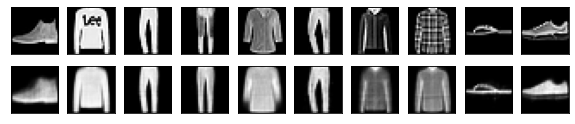

total train loss:19.699024200439453
total test loss:3.3368611335754395
[Epoch 23]


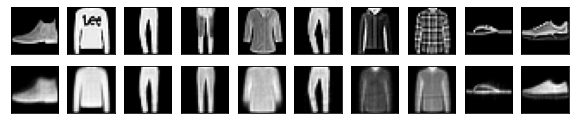

total train loss:19.616817474365234
total test loss:3.4319844245910645
[Epoch 24]


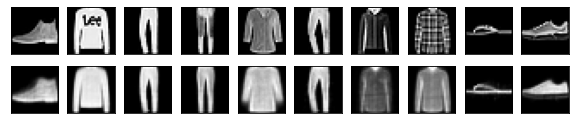

total train loss:19.6646728515625
total test loss:3.2930843830108643
[Epoch 25]


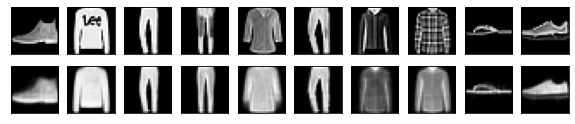

total train loss:19.544281005859375
total test loss:3.3434882164001465
[Epoch 26]


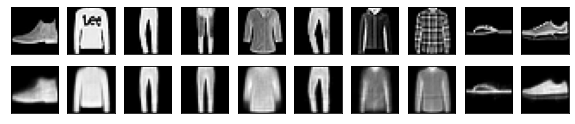

total train loss:19.600679397583008
total test loss:3.291165828704834
[Epoch 27]


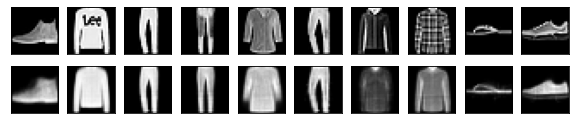

total train loss:19.60695457458496
total test loss:3.3208346366882324
[Epoch 28]


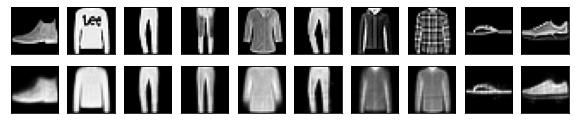

total train loss:19.52798843383789
total test loss:3.340597629547119
[Epoch 29]


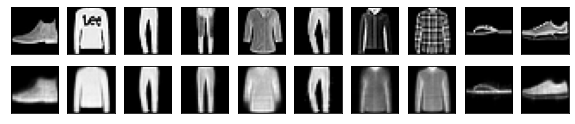

total train loss:19.516647338867188
total test loss:3.330573320388794
[Epoch 30]


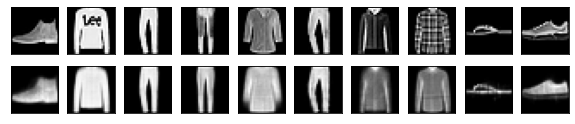

In [12]:
train_losses=[]
test_losses=[]
#학습하기
for epoch in range(1, EPOCH+1):
    loss_epoch = train(autoencoder, train_loader)
    train_losses.append(loss_epoch)

    loss_epoch = test(autoencoder, test_loader)
    test_losses.append(loss_epoch)

    test_x = view_data.to(DEVICE)
    _, decoded_data = autoencoder(test_x)

    # 원본과 디코딩 결과 비교해보기
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    print("[Epoch {}]".format(epoch))
    for i in range(10):
        img = np.reshape(view_data.data.numpy()[i],(28, 28)) #파이토치 텐서를 넘파이로 변환합니다.
        a[0][i].imshow(img, cmap='gray')
        a[0][i].set_xticks(()); a[0][i].set_yticks(())

    for i in range(10):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28)) 
        # CUDA를 사용하면 모델 출력값이 GPU에 남아있으므로 .to("cpu") 함수로 일반메모리로 가져와 numpy행렬로 변환합니다.
        # cpu를 사용할때에도 같은 코드를 사용해도 무방합니다.
        a[1][i].imshow(img, cmap='gray')
        a[1][i].set_xticks(()); a[1][i].set_yticks(())
    plt.show()

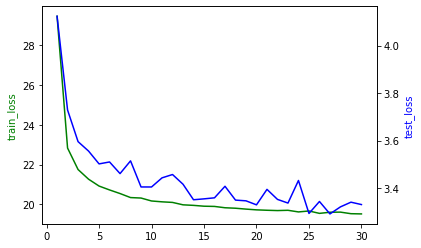

In [13]:
x = range(1,EPOCH+1)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x, train_losses, 'g-')
ax2.plot(x, test_losses, 'b-')
ax1.set_ylabel('train_loss', color='g')
ax2.set_ylabel('test_loss', color='b')
plt.show()
